In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from torch.optim import Adam
import skimage
import sklearn.metrics
import skimage.segmentation
from PIL import Image
from tqdm import tqdm_notebook

print(torch.__version__)

1.0.1.post2


data reader

In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'), np.uint8)
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.target_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        images = images
        
        return images, labels

build model DenseNet

build model ResNet

In [73]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class My_Model(nn.Module):
    def __init__(self, input_channel=1, num_class=10):
        super(My_Model, self).__init__()
        self.model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(self.model_ft, False)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        return F.softmax(x, dim=1)

show data

torch.Size([32, 96, 96, 3])


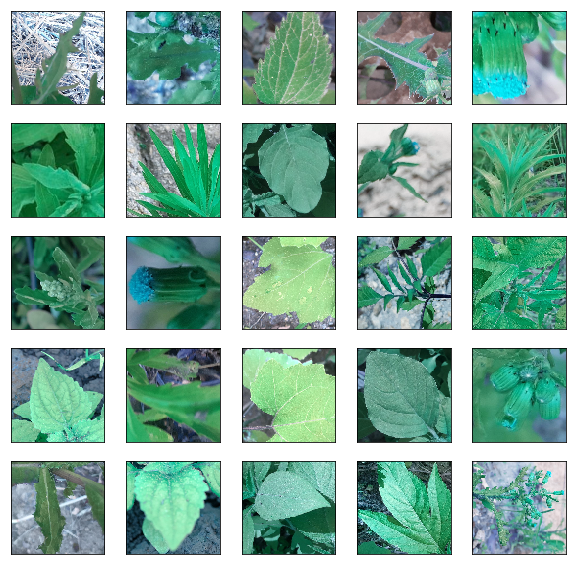

In [86]:
train_images, train_labels = next(iter(Test_dataloader))
print(train_images.size())
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

initialize the model

In [87]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_model = My_Model(num_class = NUM_CLASS)
_model.to(device)
#summary(_model, input_size= train_images[0].size())

My_Model(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

Training

Testing

predicted 5
prob 1.0
predicted 21
prob 0.0
predicted 10
prob 0.0


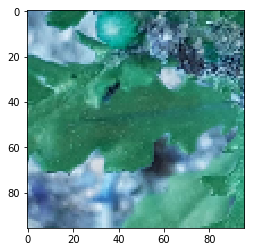

In [88]:
_model.load_state_dict(torch.load('epochs/epoch-weed.pt'), strict=False)
_model.to(device)
_model.eval()

Xi = train_images[1].cpu().numpy()
plt.imshow(Xi)
tens = (normalize(Xi)).to(device)

tens = tens.view(1, 3, 96, 96)
preds = (_model(tens)).data.cpu().numpy()[0]
res = preds.argsort()[-3:][::-1]
#print('true (likely) label:', class_name)
for i in res:
    print('predicted', imagenet_classes[i])
    print('prob', preds[i])

For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

12

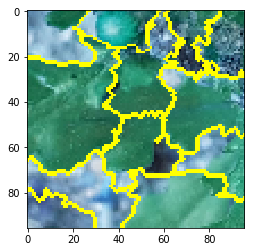

In [89]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=3,max_dist=50, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
plt.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))
num_superpixels

In [90]:
num_perturb = 800
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1])

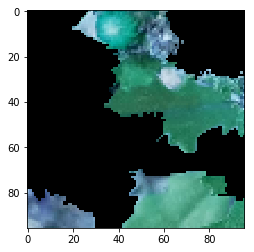

In [91]:
import copy

def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape, np.uint8)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

plt.imshow(perturb_image(Xi,perturbations[0],superpixels))

Predict the label of perturbed images (target)

In [92]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi, pert, superpixels)
    perturbed_img = transforms.ToPILImage()(perturbed_img)
    
    tens = normalize((perturbed_img)).to(device)
    tens = tens.view(1, 3, 96, 96)
    preds = (_model(tens)).data.cpu().numpy()[0]
    predictions.append(preds)

predictions = np.array(predictions)

In [93]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

train explainable model

In [94]:
from sklearn.linear_model import LinearRegression
class_to_explain = res[0]

simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_
coeff

array([ 0.00428965,  0.00022756,  0.00678242, -0.00655876,  0.01058498,
        0.01024068,  0.01059927,  0.01084715, -0.00126999, -0.0075698 ,
       -0.0077891 , -0.00825523])

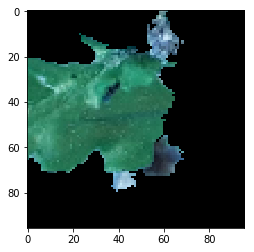

In [97]:
num_top_features = 3
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
plt.imshow(perturb_image(Xi,mask,superpixels))